# CausalityTools.jl

This is a Julia framework for estimating quantities about the "relationship" between data, typically timeseries. There are many different "relationship" quantifiers, most of which fall under the umbrella of causal inference.

In this short tutorial, we focus on only two use cases: 
- Estimating mutual information as a better correlation quantity than traditional statistical quantities
- Estimating/inferring a small causal graph out of a group of three timeseries using transfer entropy as the quantifier.

_Warning: the majority of the quantifiers in CausalityTools.jl require careful consideration for choosing their parameters. Moreover, inferring causal graphs also requires additional careful analysis to exclude common causes (also called confounding variables). These advanced topics however fall outside the scope of this introductory tutorial!_


**In-development version!** We are currently ready to published the much improved v2.0 of CausalityTools.jl and we will be using you as Guinea Pigs for it! To install this development version, use the following command:

```julia
import Pkg
Pkg.add(url = "https://github.com/JuliaDynamics/CausalityTools.jl/", rev = "v2")
```

and the documentation is here: https://juliadynamics.github.io/CausalityTools.jl/previews/PR187/ 

## Mutual information as a better measure of "correlation"

Typical correlation coefficients used in the literature such as Pearson/Spearman coefficients can misslead when estimating correlation between quantities that relate non-monotonically. For example, if $y = a \cdot x^2$ and $x \sim U(-1,1)$, both coefficients would yield 0 correlation between $y$ and $x$, even though they have such a clear relationship.

Let's demonstrate with an exemplary set of noisy timeseries

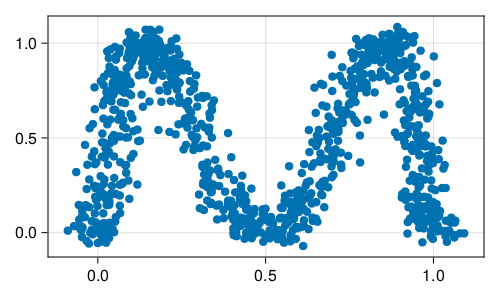

In [ ]:
using DynamicalSystems
lo, N = Systems.logistic(r=4), 1000
x = trajectory(lo, N-1)
y = trajectory(lo, N-1; Ttr = 2)
x .+= randn(N)/25; y .+= randn(N)/25
scatter(x, y)

In [ ]:
using StatsBase: cor, corspearman
cor(x, y), corspearman(x, y)

(-0.035734765797092234, -0.03405500205500205)

Practically zero correlation according to these estimators...



An established method that estimates general correlation between $x$ and $y$ is their **mutual information (MI)**. Its most basic definition is given by
$$
MI(x,y)  = \sum_{n}\sum_{m}
    P_{xy}(x_n,y_m)\log\left(\frac{P_{xy}(x_n, y_m)}{P_{x}(x_n)P_{y}(y_m)}\right)
$$
where here $P_x(x_n)$ means casting the $n$-th data point of $x$ into a probability, and $P_{xy}$ means the same but now for a joint distribution between $x,y$. Intuitively speaking, MI measures how much knowing one of these observables reduces uncertainty about the other. Mathematically speaking, MI is a measure of the distance between the joint distribution $P_{xy}$ of $x, y$, and the distribution they'd have if they were independent, i.e., $P_{xy} = P_x P_y$.

In code you can calculate $MI$ with the `mutualinfo` function.

In [ ]:
using CausalityTools

In [ ]:
mutualinfo(ValueHistogram(21), x, y)

1.0739116596364333

Just like the discussion we had in the previous blocks, there are different ways to cast the data into probabilities.

In [ ]:
mutualinfo(SymbolicPermutation(m=3), x, y)

0.40200183832440306

In addition here there are different ways to calculate the mutual information from existing probabilities (the formula quoted above is one estimator only). The interface is the same, you call `mutualinfo` but now with some other "estimator", now a "mutual information estimator" rather than a "probabilities estimator". For example

In [ ]:
mutualinfo(KraskovStögbauerGrassberger2(k=5), x, y)

0.4628888119769542

However, this is an advanced topic that goes beyond this course. 

Alright, let's now focus on the simplest case of estimating the MI, via the histograms and joint histogram, of $x, y$

In [ ]:
mutualinfo(ValueHistogram(21), x, y)

1.064821805008715

these MI numbers seem pretty random honestly. What we really care about is to be able to make a binary statement: are $x, y$ "correlated" according to this MI? To answer this, we do a surrogate test to reject the hypothesis "$x$ and $y$ are uncorrelated". What kind of surrogate generators satisfy this hypothesis by construction? Just shuffling the data, since this leaves $P_x$ and $P_y$ (and hence $P_xP_y$ invariant, but may ruin $P_{xy}$.

In [ ]:
using TimeseriesSurrogates
surrox = surrogenerator(x, RandomShuffle())
surroy = surrogenerator(y, RandomShuffle())

Surrogate generator for input timeseries 1000-element Vector{Float64} with method:
RandomShuffle()

Just like we did in the case block of TimeseriesSurrogates.jl, we will compute the discriminatory statistic, here the mutual information, for the original data and a bunch of surrogates. For comparison, we'll also do the same for the Spearman coefficient.

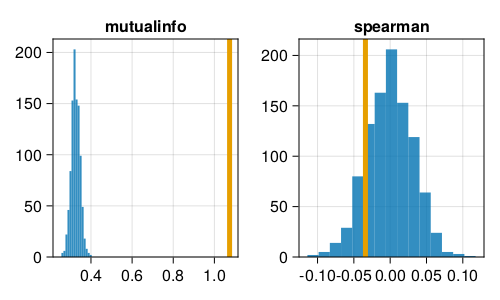

In [ ]:
measures = [
    (x, y) -> mutualinfo(ValueHistogram(21), x, y),
    corspearman
]
names = ["mutualinfo", "spearman"]

N = 1000 # how many random surrogates
function surrogate_distribution(x, y, measure, N = 1000)
    original = measure(x, y)
    surrox = surrogenerator(x, RandomShuffle())
    # Quick note: we don't _actually_ have to make a surrogate
    # for the `y` timeseries here; just shuffling the `x`
    # timeseries is enough! But for the sake of
    # demonstration we go through the process one would do
    # for any probabilities estimator
    surroy = surrogenerator(y, RandomShuffle())
    distribution = Float64[]
    for i in 1:N
        sx, sy = surrox(), surroy()
        push!(distribution, measure(sx, sy))
    end
    return original, distribution
end

fig = Figure()
for (i, measure) in enumerate(measures)
    original, distribution = surrogate_distribution(x, y, measure)
    hist(fig[1, i], distribution; axis = (title = names[i],))
    vlines!(original; color = Cycled(2), linewidth = 5)
    ylims!(0, nothing)
end
fig

## Transfer entropy for causal tsa
Transfer entropy (TE) is one of the many measures used when performing **causal timeseries analysis**. Transfer entropy is defined by:

$$
TE_{x\to y} = H(y_t | y_{t-1:t-m}) - H(y_t | y_{t-1:t-m}, x_{t-1:t-n}) 
$$
with $H(x)$ the Shannon entropy of $H$.

TE quantifies how much _extra information we gain_ for the future of one timeseries $y$ (the “target”) if we know the past of $y$ and the past of another timeseries $x$ (the “source”), versus the information we would gain by only knowing the past of $y$.

In this section we'll use TE to estimate the causal relationship between three timeseries shown below, that have a known causal graph (from generation of data) that ahs two links: $(x \to y), (y \to z)$. 

_Note: we can't use Mutual Information in this context, because it is a symmetric measure! $MI(x,y) = MI(y,x)$!_ 

### Generate autoregressive processes with known causal relationship

In [ ]:
using Random: MersenneTwister
function ar3(n::Int, rng = MersenneTwister(1234))
    x = zeros(n)
    y = zeros(n)
    z = zeros(n)
    x[1:3] .= randn(rng, 3)
    y[1:3] .= randn(rng, 3)
    z[1:3] .= randn(rng, 3)

    for i = 4:n
        x[i] = 0.6*sqrt(2)*x[i-1] - 0.71*x[i-2] + randn(rng)
        y[i] = 0.7*x[i-2] + 0.71*y[i-2] + randn(rng)
        z[i] = 0.67*z[i-2] - 0.6*y[i-1] - 0.2*z[i-3] + randn(rng)
    end
    return x, y, z
end

x, y, z = ar3(2*60*24)
data = Dict("x" => x, "y" => y, "z" => z)

Dict{String, Vector{Float64}} with 3 entries:
  "x" => [0.867347, -0.901744, -0.494479, -0.296325, 0.227705, 0.5137, 0.346335…
  "z" => [0.532813, -0.271735, 0.502334, -1.63504, -0.090054, -2.67248, 2.35223…
  "y" => [-0.902914, 0.864401, 2.21188, -0.577997, 3.07708, -0.868981, 0.840691…

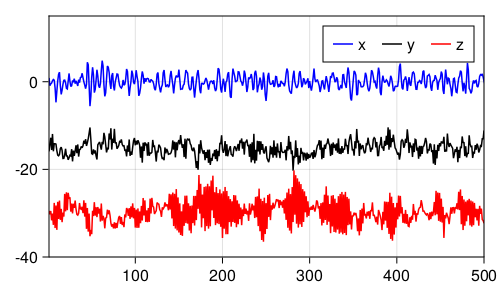

In [ ]:
lines(x; color = "blue", label = "x")
lines!(y .- 15; color = "black", label = "y")
lines!(z .- 30; color = "red", label = "z")
axislegend(nbanks = 3)
xlims!(1, 500)
ylims!(-40, 15)
current_figure()

### Estimating tranfer entropy

The main function to use is `transferentropy`, that has the call signature:
```julia
transferentropy(embedding, estimator, x, y)
```
which estimates the transfer entropy _from_ `x` _to_ `y`. We already have the two input timeseries, so we move on to the second argument, _the estimator_.

To estimate transfer entropy, just like all other measures mentioned here, one needs to cast data into probabilities in some way. There are many estimators that can be used in this context, some of which estimate directly transfer entropy, some estimate some differenetial entropy. The online documentation has more information on the estimators.

Here we will once again use the simplest possible way to cast data into probabilities: the probabilities estimator `ValueHistogram`!

In [ ]:
probest_for_te = ValueHistogram(3)

ValueHistogram{RectangularBinning{Int64}}(RectangularBinning{Int64}(3, false))

You might be surprised that we will only use 3 bins per data dimension... Sounds pretty low right? Well, yes, but you need to take into account how many data dimensions we have when attempting to compute transfer entropy. Recall that we need to compute the entropy:
$$
H(y_t | y_{t-1:t-m}, x_{t-1:t-n})
$$
The first argument is a timeseries, so 1 dimension. However, the second has `m-1` dimensions, because each "data point" of $y_{t-1:t-m}$ is composed of `m-1` values from the $y$ timeseries! Hence, we need to compute a histogram in `m-1` dimensional space. Even worse, we also need the _joint_ histograms! And in the case where we include also the past of `x`, our dimension becomes in total `m + n - 1` which can get very large depending on how much of the past we include!

Hence, we need to be reserved in how many bins we will use for the histograms, because if we use a lot of bins most of them will be empty, leading to low accuracy in the computation of the transfer entropy.

There the last argument we need to choose is `embedding`, the **delay embedding** of the data. Without going into too many details, for this application this means choosing `m, n`, i.e., how much of the past of $y$ and $x$ to include.

This decision is encapsulated in an instance of `EmbeddingTE` (standing for "embedding for transfer entropy"), like so:

In [ ]:
using CausalityTools
emb_for_te = EmbeddingTE(; dS = 3, dT = 4)

EmbeddingTE(dS=3, dT=4, dC=1, dTf=1, τS=-1, τT=-1, τC=-1, ηTf=1)

Here `dS` meant the "embedding dimension of the Source" and `dT` meant the "embedding dimension of the Target" (TE is estimated _from_ source $x$ _to_ target $y$). Other arguments are things that we will not discuss in this lecture!

In any case, now we can use this embedding information, and the probabilities estimator, into the `transferentropy` function as follows:

In [ ]:
transferentropy(emb_for_te, probest_for_te, x, y)

0.19223144391518066

Just like it was the case with mutual information, the significance of this number can be estimated via surrogate tests, which we will do in a moment!

### Optimizing parameters for the estimation

Estimating the TE like above has lots of input choices regarding the number of bins and how far to go into the past. The number of bins is constrained by the amount of data we have, but how far into the past we can go can be optimized using standard nonlinear dynamics techniques included in the DelayEmbeddings.jl package.

In CausalityTools.jl we have made a simple wrapper function that uses DelayEmbeddings.jl and provides an optimized embedding for given `x, y` timeseries that go into `transferentropy`. You can call it as follows:

In [ ]:
optimal_embedding = optimize_marginals_te(OptimiseTraditional(), x, y; exclude_source = true)

EmbeddingTE(dS=1, dT=5, dC=1, dTf=1, τS=-1, τT=-1, τC=-1, ηTf=1)

In [ ]:
transferentropy(optimal_embedding, probest_for_te, x, y)

0.05541655551424807

### Causal graph from transfer entropy

Alright! Now we are ready to compute the TE between all _directional_ pairs of the three timeseries `x, y, z`. These pairs are:

In [ ]:
using Combinatorics: multiset_permutations
variable_pairs = multiset_permutations(("x", "y", "z"), 2)
collect(variable_pairs)

6-element Vector{Vector{String}}:
 ["x", "y"]
 ["x", "z"]
 ["y", "x"]
 ["y", "z"]
 ["z", "x"]
 ["z", "y"]

In [ ]:
results_te = Dict{String, Float64}()
for (source, target) in variable_pairs
    s, t = data[source], data[target]
    est = ValueHistogram(3)
    # Shannon transfer entropy with traditional delay-embedding optimisation. 
    # Skip optimising for source time series (you don't need to understand this now). 
    embedding = optimize_marginals_te(OptimiseTraditional(), s, t; exclude_source = true)
    results_te["$source → $target"] = transferentropy(embedding, est, s, t) 
end
results_te

Dict{String, Float64} with 6 entries:
  "x → y" => 0.0554166
  "x → z" => 0.0276461
  "y → z" => 0.107256
  "z → x" => 0.0310366
  "y → x" => 0.0371841
  "z → y" => 0.0360582

Very nice! This is already a "causal graph" (terms and conditions apply), with the strength of the links being the above numbers.

### Eliminating insignificant links

The above "causal graph" is fully connected. We can do much better than that, by eliminating insignificant or spurrious links in the graph via surrogate tests! For each pair in this graph, we have to make a dedicated surrogate test, very similar in spirit with the example of the mutual information.
 
Because the probabilities estimator is `ValueHistogram`, the appropriate surrogates are those generated with simply shuffling the timeseries around!

In [ ]:
results_surr = Dict()
nsurr = 100
for (source, target) in variable_pairs
    s, t = data[source], data[target]
    est = ValueHistogram(3)
    # Optimise transfer entropy parameters *before* computing transfer entropy on
    # surrogate data, so that we use identical parameters for real and shuffled data. 
    embedding = optimize_marginals_te(OptimiseTraditional(), s, t; exclude_source = true)
    ŝ = surrogenerator(s, RandomShuffle())
    te_surr = [transferentropy(embedding, est, ŝ(), t) for i = 1:nsurr]
    results_surr["$source → $target"] = te_surr
end
results_surr

Dict{Any, Any} with 6 entries:
  "x → y" => [0.0433005, 0.0398284, 0.0428038, 0.0394565, 0.0358692, 0.0396165,…
  "x → z" => [0.0265681, 0.0250555, 0.0315874, 0.0293445, 0.0243791, 0.0303093,…
  "y → z" => [0.0230548, 0.0318878, 0.0310125, 0.0312579, 0.0253844, 0.0299137,…
  "z → x" => [0.0319399, 0.0297704, 0.0315703, 0.0313589, 0.0347524, 0.0315343,…
  "y → x" => [0.0409778, 0.0338697, 0.0416263, 0.0286575, 0.03992, 0.0300415, 0…
  "z → y" => [0.0354153, 0.0453079, 0.0382885, 0.0399693, 0.0413016, 0.0469605,…

In these results, each pair is mapped to a _distribution_ of the TE values for surrogate data. So, just like in the MI case, we check whether the real TE value is outside the majority of the distribution mass, e.g., beyond the 1-99 quantiles. 

Here is a nice visualization that shows this!

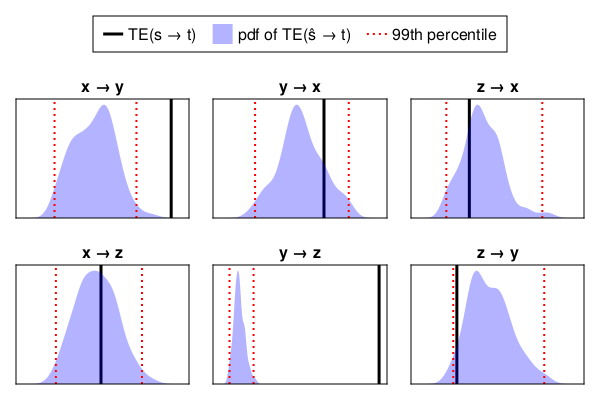

In [ ]:
using Statistics: quantile
α = 0.01 # quantile

fig = Figure(resolution = (600,400))
names = sort(collect(keys(results_te)))
axs = [Axis(fig[idx[1], idx[2]]) for idx in CartesianIndices((2, 3))]

for (ax, name) in zip(axs, names)
    vlines!(ax, results_te[name], color = :black, linewidth = 3,
            label = "TE(s → t)")
    density!(ax, results_surr[name], color = (:blue, 0.3),
            label = "pdf of TE(ŝ → t)");
    vlines!(ax, quantile(results_surr[name], [α, 1-α]), 
            label = "$(ceil(Int, (1-α)*100))th percentile",
            color = :red, linestyle = :dot, linewidth = 2)
    hidedecorations!(ax)
    ylims!(ax, 0, nothing)
    ax.title = name
end
fig[0, :] = Legend(fig, content(fig[1,1]), nbanks = 3, tellheight = true)
fig

Fantastic! We can see that the TE correctly inferred the causal graph $(x \to y), (y \to z)$ when taking into account the surrogate significance tests! TE also claims that the influence of $y$ on $z$ is much larger than the influence of $x$ on $y$. However what this means when it comes down to the causal relationship is ambiguous.

### Concluding remarks

- Transfer entropy is just one method for detecting directional influences from time series.
- The pairwise analysis you did here is as naive as possible. In real applications, parameters must be tuned carefully!
- In real applications, you also need to do a conditional variant to account for _confounding variables_ (also called _common drivers_). This variant is called "partial transfer entropy".
- Many very sophisticated and powerful methods for inferring causal graphs using conditional independence testing exist (see e.g. [Runge et al. 2019 Nat. Comm.](https://www.nature.com/articles/s41467-020-15195-y/)).

# Exercises - relational timeseries analysis

## MI of atmospheric reflectance timeseries

Use the following code snippet to load the same atmospheric reflectance data as those used in the TimeseriesSurrogates.jl exercise, but now de-trended:

In [ ]:
using Downloads, DelimitedFiles
file = joinpath(@__DIR__, "..", "data", "atmospheric_reflectance_detrended.tsv")
M = readdlm(file)
x, y = M[:, 1], M[:, 2];

Utilize the `mutualinfo` function from CausalityTools.jl examine if the two timeseries are significantly correlated. Repeat our attempt also with using two more different estimators for the probabilities going into mutual information: `Dispersion()` and `SymbolicPermutation(m = 3)`.

_Note: in this exercise you are essentially reproducing the research of section 3.2 of [Datseris & Stevens (2021), Earth's Albedo and Its Symmetry](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021AV000440)_

## Importance of parameters in an output value

Imagine you have some model, that is generating a trajectory, and from the trajectory you extract one quantity (a real number) that is of interest to you. Your model has many parameters, and you want to quantify which of the model parameters significantly affect the value of your quantity of interest.

This is a scenario where a simple application of mutual information gives the wanted information. Use the following code to load a dataset:

In [ ]:
using DelimitedFiles
data = readdlm(joinpath(@__DIR__, "..", "data", "parameter_importance.csv"))
x = data[:, 1]
params = data[:, 2:end];

In this data, the first column `x` is an output diagnostic of some model evolution, and the rest of the columns are input parameters to the model. Use a mutual information analysis to order the parameters by their importance in shaping the value of `x`. A measure of importance can be the **normalized mutual information**, which is defined based on the distribution of MI values one obtains from the surrogate test:

$$
nMI = \frac{|MI - mean(D)|}{3 std(D)}
$$
with $D$ the distribution and $MI$ the real MI value. (of course, instead of $3\sigma$ you could use the width of the central 1-99% quantile or anything else). $nMI>1$ means significant correlation, or in this case importance of the parameter, and the larger the $nMI$ the larger the importance.

_hint: the input data here are not ordered timeseries. As such, the probabilities estimator that makes most sense to use is `ValueHistogram`_

_Note: in this exercise you are essentially reproducing the research of section 5 of [Schmidt & Hohenegger (2023), to be published](https://mpimet.mpg.de/en/staff/atmosphere/translate-to-englisch-luca-schmidt-1)_

## Estimator dependence of the TE causal graph application

The choice of estimator will (sometimes strongly) affect a TE-based analysis. In the hHere we used the naive `ValueHistogram(3)` discrete probabilities estimator. It computes transfer entropy as a sum of four entropy terms, without any bias correction. 

`ValueHistogram(3)` uses 3 subdivisions along each dimension to construct bins. The minimum dimension of the embedding for a transfer entropy analysis is 3. Therefore, for `ValueHistogram(3)`, there are _at least_ `3^3 = 27` possible bins/states which observations can occupy. What do you think happens to the reliability of the entropy estimates (and thus the transfer entropy estimate) when increasing the number of boxes? Does it increase or decrease? Repeat the TE example showed here for `ValieHistogram(b)` with `b` from `2` to `7`.

Then, repeat the example, now using a completely different estimator: `Zhu1(; k = length(x) ÷ 40)`. The `Zhu1` estimator computes *differential* transfer entropy, and has built-in bias-correction.

## Causal direction in timeseries pairs

Use the following code to download a pair of timeseries `x, y` from datasets 14 or 15:

In [ ]:
using Downloads, DelimitedFiles
data_number = 14 # 14 or 15
file = Downloads.download("https://raw.githubusercontent.com/JuliaDynamics/NonlinearDynamicsTextbook/master/exercise_data/$(data_number).csv")
x, y = eachcol(DelimitedFiles.readdlm(file));

Perform a transfer entropy analysis of the two timeseries, and use that to deduce whether one timeseries is a causal driver of the other or if no significant causal direction can be inferred.

_hint: as it is not known whether the timeseries represent discrete-time processes, it is not clear what whether the delay time should be equal to 1, and you probably want to optimize this_